# Utilisation du modèle Mask R-CNN

Ce notebook complète l'article publié sur le blog de Makina Corpus à propos de l'**extraction d'objets pour la cartographie par deep-learning**, et plus particulièrement le [choix du modèle](https://makina-corpus.com/blog/metier/2020/extraction-dobjets-pour-la-cartographie-par-deep-learning-choix-du-modele).

Nous présentons ici comment utiliser l'implémentation du modèle **Mask R-CNN** (disponible ici : [Matterport-Mask RCNN](https://github.com/matterport/Mask_RCNN/blob/master)) : 
* **Comment entrâiner ce modèle de segmentation d'instance pour la détection d'objets ?**
* **Comment réaliser des prédictions sur des images ?**

Ce notebook nécessite de cloner le répertoire Mask RCNN :
```console
git clone https://github.com/matterport/Mask_RCNN.git
```

Il necessite aussi l'installation de plusieurs bibliothèques Python
* **`scikit-image`**
* **`tensorflow`** et **`keras`**
* **`pycocotools`** (voir commande ci-dessous)
```console
pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI
 ```
 
 

### Imports 

In [1]:
# IMPORT LIBRAIRIES
import os
import sys
import time
import json
import random
import math
import numpy as np

# pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

# mrcnn
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# visualisation
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import PIL


Using TensorFlow backend.


## Définition des variables et des dossiers nécessaires 

Nous utiliserons dans ce tutoriel les poids du modèle déjà entraîné : [submitted_weights.h5](https://gitlab.com/LaurentS/crowdai-mapping-challenge-mask-rcnn/-/blob/master/submitted_weights.h5) de cette [solution](https://gitlab.com/LaurentS/crowdai-mapping-challenge-mask-rcnn)
 au challenge Crowd AI Mapping challenge.
 
Le dossier "logs" correspond au dossier dans lequel les différents poids obtenus par l'entraînement du modèle seront enregistrés. 

In [2]:
#Preparation des chemins
ROOT_DIR = ""
PRETRAINED_MODEL_PATH ="submitted_weights.h5"
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

## ENTRAINEMENT

### Configuration du modèle pour l'entrainement.

La configuration du modèle va varier selon le mode de fonctionnement du modèle. L'implémentation de Mask R-CNN contient déjà une classe pour la configuration du modèle : la classe `Config` de `mrcnn.config`.

Il suffit donc de créer une classe qui hérite de celle-ci pour configurer le modèle à notre utilisation. 

Dans le cas de l'entraînement, les paramètres  importants sont :
   - `IMAGES_PER_GPU` et `GPU_COUNT` qui permettent de définir la taille du lot (`BATCH_SIZE`). Celle-ci est calculée comme étant le produit de ces deux variables.
   - `STEPS_PER_EPOCH` qui défnit le nombre d'itérations par époques.
   - `VALIDATION_STEPS` qui définit le nombre d'itérations pour la validation.


In [3]:
# configuration du modèle pour l'entrainement
class Buildings_Config(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Nom du modèle 
    NAME = "Buildings_Detection"

    # Paramètres définisssant la taille du lot (batch size) égale à IMAGES_PER_GPU * GPU_COUNT
    IMAGES_PER_GPU = 5
    GPU_COUNT = 1

    # Nombre de catégories incluant le background
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building

    STEPS_PER_EPOCH=1000  
    VALIDATION_STEPS=50
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256

    
# initialisation de la configuration du modèle
config = Buildings_Config()

# visualisation de la configuration.
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Initialisation du modèle en mode "Entraînement"

Nous initions le modèle en mode *training* avec la configuration définie précédemment.
Comme nous avons à notre disposition un modèle déjà entraîné, nous pouvons utiliser les poids de ce modèle pour entraîner notre modèle à partir de celui-ci par technique d'**apprentissage par transfert**.

In [ ]:
# INITIALISATION EN MODE ENTRAINEMENT
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)  
model_path = PRETRAINED_MODEL_PATH

# chargement des poids du modèle déja entraîné
model.load_weights(model_path, by_name=True)

### Configuration du jeu de données

Pour que notre jeu de données puisse être utilisé par le modèle, il est nécessaire de le décricre via une classe de configuration, tout comme la configuration du modèle que nous venons de réaliser. Cette classe hérite de la classe `Dataset` de `mrcnn.utils` et s'adapte à notre vérité terrain.

Sa principale fonctionnalité est de permettre le chargement du fichier d'annotations et d'en extraire les informations qui y sont contenues. Elle permet aussi la conversion des masques dans un format pouvant être lu et utilisé par le modèle.

In [ ]:
# CLASSE PERMETTANT LA CONFIGURATION DU DATASET

class BuildingDataset(utils.Dataset):
    
    """ Part 1 : Download Annotation file """
    
    def load_dataset(self,annotation_file,image_dir,return_coco=True, limit=None):
        """
        return COCO dataset
        """
        # COCO DATASET
        self.coco = COCO(annotation_file)
        self.image_dir =image_dir
        
        # DATASET INFORMATIONS
        # Load all classes (Only Building in this version)
        classIds = self.coco.getCatIds()
        # Load all images
        image_ids = list(self.coco.imgs.keys())[:limit]
        print(len(image_ids), 'images loaded')
        # register classes
        for _class_id in classIds:
            self.add_class("buildings_data", _class_id, self.coco.loadCats(_class_id)[0]["name"])
        # Register Images
        for _img_id in image_ids:
            assert(os.path.exists(os.path.join(image_dir, self.coco.imgs[_img_id]['file_name'])))
            self.add_image(
                "buildings_data", image_id=_img_id,
                path=os.path.join(image_dir, self.coco.imgs[_img_id]['file_name']),
                width=self.coco.imgs[_img_id]["width"],
                height=self.coco.imgs[_img_id]["height"],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                                            imgIds=[_img_id],
                                            catIds=classIds,
                                            iscrowd=0)))

        if return_coco:
            return self.coco
        
        
    """ Part : Download Mask """    

    def load_mask(self, image_id):
        """ Loads instance mask for a given image
              This function converts mask from the coco format to a
              a bitmap [height, width, instance]
            Params:
                - image_id : reference id for a given image

            Returns:
                masks : A bool array of shape [height, width, instances] with
                    one mask per instance
                class_ids : a 1D array of classIds of the corresponding instance masks)
        """

        image_info = self.image_info[image_id]
        assert image_info["source"] == "buildings_data"

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "buildings_data.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation,  image_info["height"],
                                                image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue

                # Ignore the notion of "is_crowd" as specified in the coco format
                # as we donot have the said annotation in the current version of the dataset

                instance_masks.append(m)
                class_ids.append(class_id)
        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            
            
            return mask,class_ids  

        else:
            # return an empty mask if no instance for the given image.
            mask = np.empty([0, 0, 0])
            class_ids = np.empty([0], np.int32)
            return mask, class_ids

   
     
    """Part : Tools to convert masks """
    
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

### Preparation des jeux de données 

Une des bonnes pratiques à mettre en place lorsque l'on travaille avec des algorithmes d'apprentissage supervisé est de découper la vérité terrain disponible en deux jeux de données : un **jeu d'entraînement** et un **jeu de test**.

Dans notre cas, chacun de ces jeux de données doit être constitué d'un dossier images et d'un fichier d'annotations au format COCO.

Nous utilisons donc la classe `BuildingDataset()` définie précédemment avec ces deux jeux de données :

In [ ]:
# PREPARATION DU DATASET
# fichiers train
annot_file_train="fichier annotation pour l'entrainement.json"
img_directory_train="Dossier images pour l'entrainement"
# fchiers validation
annot_file_val="fichier annotation pour la validation.json"
img_directory_val="Dossier images pour la validation"

# train dataset
data_train = BuildingDataset()
coco_data_train = data_train.load_dataset(annot_file_train,img_directory_train,return_coco=True)
data_train.prepare() 

#validation dataset
data_val= BuildingDataset()
coco_data_val = data_val.load_dataset(annot_file_val,img_directory_val,return_coco=True)
data_val.prepare() 

### Entrainement

Le modèle initialisé et les jeux de données prêts , nous pouvons lancer l'entrainement.
Nous rappelons que lors de l'initialisation du modèle, nous avons chargé les poids d'un modèle pré-entrainé. Il est possible de ne pas effectuer cette étape et d'entrainer le modèle sans.

La fonction model.train() permet d'effectuer l'entraînement, elle prend en paramètres d'entrée :
* le jeu d'entraînement
* le jeu de test
* le taux d'apprentissage
* le nombre d'époques
* les couches que nous souhaitons entrâinées

De plus, comme vu précédemment, la configuration du modèle contient les paramètres de la taille de lots, le nombre d'étapes par époques.


In [ ]:
# Exemple d'entrainement de toutes les couches du modèle sur 60 époques
model.train(
    dataset_train, 
    dataset_val, 
    learning_rate=config.LEARNING_RATE, 
    epochs=60, 
    layers="all"
)

## PREDICTIONS 

Avec le fichier contenant les poids , il est possible de réaliser des prédictions. Pour cela nous devons configurer le modèle et l'intialiser en mode inférence.

### Configuration du modèle pour la prédiction

Tout comme pour la configuration en mode entraînement, nous utilisons une classe qui hérite de la classe `Config`.


In [14]:
### CONFIGURATION DU MODELE POUR LA PREDICTION ET L EVALUATION

class Buildings_Inference(Config):
    NAME = "Buildings_Detection"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Nous avons une catégorie "Buildings" , le background étant la catégorie par défaut, cela donne : 1 Background + 1 Building
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
    DETECTION_MIN_CONFIDENCE = 0.999 # c'est le seuil de confiance (score de prédiction) à partir du quel on veut que le modèle valide la détection de l'objet.

# initialisation de la configuration du modèle   
config = Buildings_Inference()

# visualisation de la configuration
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.999
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

### Chargement du modèle 

Nous initions le modèle en mode inférence avec la configuration définie précédemment.
Comme nous avons à notre disposition un modèle déjà entraîné, nous pouvons charger les poids de ce modèle pour la prédiction appliquée à nos données.

In [17]:
# CHARGEMENT DU MODELE ET CHARGEMENT DES POIDS DU MODELE PRE-ENTRAINE
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config) 
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True) #téléchargement des poids du modèle déja entrainé
class_names = ['BG', 'buildings'] # Liste contenant le nom des catégories, permettant la visualisation du nom des catégories détectées

### Prédiction

 Visualisation de l'image sur laquelle nous voulons détecter des bâtiments :

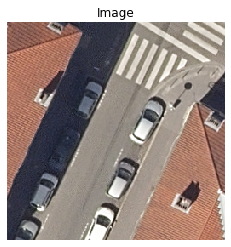

In [18]:
# IMAGE SUR LAQUELLE NOUS APPLIQUONS LA PREDICTION
image = skimage.io.imread("image_lyon.tif")
plt.imshow(image)
plt.title("Image")
plt.axis('off')
plt.show()

La fonction pour effectuer une prédiction est la fonction `model.detect()`.

Elle prend en entrée un liste contenant l'image sur laquelle appliquer la prediction. Le paramètre `verbose` permet l'affichage des résultats.

In [21]:
# prédiction
results = model.detect([image],verbose=1)

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.80000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


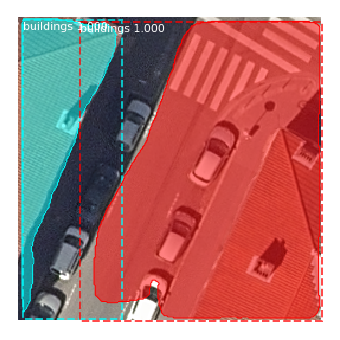

In [22]:
# visualisation de l'image avec les masques et boîtes englobantes prédites
p = results[0]
visualize.display_instances(
    image, 
    p['rois'], 
    p['masks'], 
    p['class_ids'], 
    class_names, 
    p['scores'],
    figsize=(12, 6)
)

In [23]:
# Affichage du résultat de la prédiction se présentant sous la forme d'un dictionnaire
results[0]

{'rois': array([[  1,   3, 254,  87],
        [  3,  52, 256, 256]], dtype=int32),
 'class_ids': array([1, 1], dtype=int32),
 'scores': array([0.9999503 , 0.99992716], dtype=float32),
 'masks': array([[[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        ...,
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [